In [2]:

%load_ext autoreload
%autoreload 2
import pickle
from datetime import datetime
import numpy as np
from qutip import *
import os
from matplotlib import pyplot as plt
import sys
from scipy.integrate import solve_ivp
import sandbox as sb
import importlib
importlib.reload(sb)

<module 'sandbox' from '/home/saha/Desktop/tesis/colera/redfield_polaron/sandbox.py'>

In [48]:
def calculate_tdep_redfield_dynamics_polaron2(parameters):
    """T dependent redfield dynamics using polaron"""

    N = parameters['N']
    cavity_diss_rate = parameters['cavity_diss_rate']
    input_power = parameters['input_power']
    rabi_freq = parameters['rabi_freq']
    eff_coupling = parameters['eff_coupling']
    qubit_detuning = parameters['qubit_detuning']
    cavity_drive_amplitude = parameters['cavity_drive_amplitude']
    cavity_detuning = parameters['cavity_detuning']
    norm = parameters['norm']
    final_time__mus = parameters['final_time__mus'] 
    time_steps = parameters["time_steps"]
    psi0_atom = parameters['initial_state_qubit']
    tlist = np.linspace(0, final_time__mus, time_steps)/(10**6)


    cavity_field_e = cavity_drive_amplitude/(-(cavity_detuning + eff_coupling) + .5j*cavity_diss_rate)
    cavity_field_g = cavity_drive_amplitude/(-(cavity_detuning - eff_coupling) + .5j*cavity_diss_rate)

    photon_number_e = np.abs(cavity_field_e)**2
    photon_number_g = np.abs(cavity_field_g)**2

    beta = cavity_field_e - cavity_field_g

    qubit_detuning_lamb_shift = eff_coupling*(np.abs(beta)**2 + 2*np.real(cavity_field_e*np.conj(cavity_field_g))+1)
    diag_qubit_freq = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5
    
    #Norm everything
    tlist__N = tlist*norm
    cavity_detuning__N = cavity_detuning/norm
    cavity_drive_amplitude__N = cavity_drive_amplitude/norm
    qubit_detuning__N = qubit_detuning/norm
    eff_coupling__N = eff_coupling/norm
    rabi_freq__N = rabi_freq/norm
    cavity_diss_rate__N = cavity_diss_rate/norm
    qubit_detuning_lamb_shift__N = qubit_detuning_lamb_shift/norm
    diag_qubit_freq__N = diag_qubit_freq/norm


    parameters_red = parameters
    parameters_red["diag_qubit_freq__N"] = diag_qubit_freq__N
    parameters_red["cavity_detuning__N"] = cavity_detuning__N
    parameters_red["cavity_diss_rate__N"] = cavity_diss_rate__N
    parameters_red["eff_coupling__N"] = eff_coupling__N
    parameters_red["photon_number_e"] = photon_number_e
    parameters_red["photon_number_g"] = photon_number_g


    ### Qubit Hamiltonian ###
    sz = sigmaz()
    sx = sigmax()
    sm = sigmam()

    sz_matrix = sz.full()
    sx_matrix = sx.full()
    sm_matrix = sm.full()
    H_qubit_matrix = .5*diag_qubit_freq__N*sz_matrix

    ### Coupling operators
    theta = np.arctan2(rabi_freq__N,qubit_detuning_lamb_shift__N)

    oper_ee = (basis(2,0)*basis(2,0).dag()).full()
    oper_eg = (basis(2,0)*basis(2,1).dag()).full()
    oper_ge = (basis(2,1)*basis(2,0).dag()).full()
    oper_gg = (basis(2,1)*basis(2,1).dag()).full()


    s1 = eff_coupling__N*(np.cos(theta/2)**2*oper_ee + np.sin(theta/2)*np.cos(theta/2)*(oper_eg + oper_ge)+np.sin(theta/2)**2*oper_gg)
    s2 = eff_coupling__N*(-np.sin(theta/2)**2*oper_ee + np.sin(theta/2)*np.cos(theta/2)*(oper_eg + oper_ge)-np.cos(theta/2)**2*oper_gg)

    Z1op_term1__N = (np.cos(theta/2)**2*oper_ee + np.sin(theta/2)**2*oper_gg)/(1j*(cavity_detuning__N + eff_coupling__N) - cavity_diss_rate__N/2)
    Z1op_term2__N = (np.cos(theta/2)*np.sin(theta/2)*oper_eg)/(1j*(cavity_detuning__N + eff_coupling__N + diag_qubit_freq__N) - cavity_diss_rate__N/2)
    Z1op_term3__N = (np.cos(theta/2)*np.sin(theta/2)*oper_ge)/(1j*(cavity_detuning__N + eff_coupling__N - diag_qubit_freq__N) - cavity_diss_rate__N/2)

    parameters_red["Z1op_term1__N"]=Z1op_term1__N
    parameters_red["Z1op_term2__N"]=Z1op_term2__N
    parameters_red["Z1op_term3__N"]=Z1op_term3__N



    Z2op_term1__N = -(np.cos(theta/2)**2*oper_ee + np.sin(theta/2)**2*oper_gg)/(1j*(cavity_detuning__N - eff_coupling__N) - cavity_diss_rate__N/2)
    Z2op_term2__N = (np.cos(theta/2)*np.sin(theta/2)*oper_eg)/(1j*(cavity_detuning__N - eff_coupling__N + diag_qubit_freq__N) - cavity_diss_rate__N/2)
    Z2op_term3__N = (np.cos(theta/2)*np.sin(theta/2)*oper_ge)/(1j*(cavity_detuning__N - eff_coupling__N - diag_qubit_freq__N) - cavity_diss_rate__N/2)


    parameters_red["Z2op_term1__N"] = Z2op_term1__N
    parameters_red["Z2op_term2__N"] = Z2op_term2__N
    parameters_red["Z2op_term3__N"] = Z2op_term3__N
    
    U = (1j * theta/2 * sigmay()).expm()

    rho0 = U*psi0_atom@psi0_atom.dag()*U.dag()
    rho0_matrix = rho0.full()
    rho0_vectorized = rho0_matrix.flatten()
    max_step =  0.05/np.max([diag_qubit_freq__N, eff_coupling__N])

    sol = solve_ivp(tdep_redfield_master_equation_polaron2, (tlist__N[0], tlist__N[-1]), rho0_vectorized, method="DOP853",
                    t_eval=tlist__N, max_step=max_step, args=(H_qubit_matrix, parameters_red, [s1, s2]))

    full_dynamics = sol.y.T.reshape(time_steps, 2, 2)

    dynamics = [U.dag()*Qobj(i, dims=[[2], [2]])*U for i in full_dynamics]
    return dynamics

def tdep_redfield_master_equation_polaron2(t, rho_vec, hamiltonian, parameters, S_operators):

    Z_operators = tdep_Z_operators_polaron2(parameters, t)

    return redfield_master_equation2(t, rho_vec, hamiltonian, Z_operators, S_operators)
    
def tdep_Z_operators_polaron2(parameters, t):


    Z1op_term1__N = parameters["Z1op_term1__N"]
    Z1op_term2__N = parameters["Z1op_term2__N"]
    Z1op_term3__N = parameters["Z1op_term3__N"]
    
    
    Z2op_term1__N = parameters["Z2op_term1__N"]
    Z2op_term2__N = parameters["Z2op_term2__N"]
    Z2op_term3__N = parameters["Z2op_term3__N"]
    
    diag_qubit_freq__N = parameters["diag_qubit_freq__N"]
    cavity_diss_rate__N = parameters["cavity_diss_rate__N"]
    cavity_detuning__N = parameters["cavity_detuning__N"]
    eff_coupling__N = parameters["eff_coupling__N"]
    photon_number_e = parameters["photon_number_e"]
    photon_number_g = parameters["photon_number_g"] 

    term1 = Z1op_term1__N*(np.exp(1j*(cavity_detuning__N + eff_coupling__N)*t - cavity_diss_rate__N*t)-1)
    term2 = Z1op_term2__N*(np.exp(1j*(diag_qubit_freq__N + (cavity_detuning__N + eff_coupling__N))*t - cavity_diss_rate__N*t)-1)
    term3 = Z1op_term3__N*(np.exp(1j*(-diag_qubit_freq__N + (cavity_detuning__N + eff_coupling__N))*t - cavity_diss_rate__N*t)-1)

    u1 =  eff_coupling__N*photon_number_e*(term1 + term2 + term3)

    term1 = Z2op_term1__N*(np.exp(1j*(cavity_detuning__N - eff_coupling__N)*t - cavity_diss_rate__N*t)-1)
    term2 = Z2op_term2__N*(np.exp(1j*(diag_qubit_freq__N + (cavity_detuning__N - eff_coupling__N))*t - cavity_diss_rate__N*t)-1)
    term3 = Z2op_term3__N*(np.exp(1j*(-diag_qubit_freq__N + (cavity_detuning__N - eff_coupling__N))*t - cavity_diss_rate__N*t)-1)

    u2 =  eff_coupling__N*photon_number_g*(term1 + term2 + term3)

    return [u1, u2]


def redfield_master_equation2(t, rho_vec, hamiltonian, Z_operators, S_operators):
    d = int(len(rho_vec)**.5)
    rho = rho_vec.reshape(d, d)

    S_operators1 = [S_operators[0]]
    Z_operators1 = [Z_operators[0]]
    Z_conj1 = np.conj(Z_operators1)
    
    term1 = np.einsum('nij,jk,nkl->il', Z_operators1, rho, S_operators1)
    term2 = np.einsum('nij,jk,nlk->il', S_operators1, rho, Z_conj1)
    term3 = np.einsum('nij,njk,kl->il', S_operators1, Z_operators1, rho)  
    term4 = np.einsum('ij,nkj,nkl->il', rho, Z_conj1, S_operators1)     
    
    redfield_part = term1 + term2 - term3 - term4

    S_operators2 = [S_operators[0]]
    Z_operators2 = [Z_operators[0]]
    Z_conj2 = np.conj(Z_operators2)
    
    term1 = np.einsum('nij,jk,nkl->il', Z_operators2, rho, S_operators2)
    term2 = np.einsum('nij,jk,nlk->il', S_operators2, rho, Z_conj2)
    term3 = np.einsum('nij,njk,kl->il', S_operators2, Z_operators2, rho)  
    term4 = np.einsum('ij,nkj,nkl->il', rho, Z_conj2, S_operators2)

    redfield_part += term1 + term2 - term3 - term4


    coherent_part = -1j*(np.einsum('ij,jk',hamiltonian, rho) - np.einsum('ij,jk', rho, hamiltonian))
    
    drho = coherent_part + redfield_part
    return drho.flatten()



In [47]:
N = 10
cavity_diss_rate = (4.3)*2*np.pi*10**6
eff_coupling = (1)*2*np.pi*10**6
input_power = (0)
rabi_freq = (20)*2*np.pi*10**6
qubit_targetz = (0)*2*np.pi*10**6
final_time__mus = 2
time_steps = 1000
tlist = np.linspace(0, final_time__mus, time_steps)
norm = eff_coupling
target_state = 'down'

parameters = {
    "N": N,
    "final_time__mus": final_time__mus,
    "time_steps": time_steps,
    "input_power": input_power,
    "rabi_freq": rabi_freq,
    "eff_coupling": eff_coupling,
    "qubit_targetz": qubit_targetz,
    "cavity_diss_rate": cavity_diss_rate,
    "norm": norm,
    "target_state": target_state
}


parameters = sb.calculate_cavity_drive_amplitude_normal_shift(parameters)
cavity_drive_amplitude = parameters['cavity_drive_amplitude']
parameters = sb.get_initial_cavity_state_normal_shift(parameters)
parameters = sb.get_initial_qubit_state(parameters)

parameters_polaron = sb.calculate_parameters_polaron(parameters)
dynamics_polaron = sb.calculate_full_dynamics(parameters_polaron)
print("polaron")
dynamics_tdep_redfield = calculate_tdep_redfield_dynamics_polaron2(parameters_polaron)



polaron


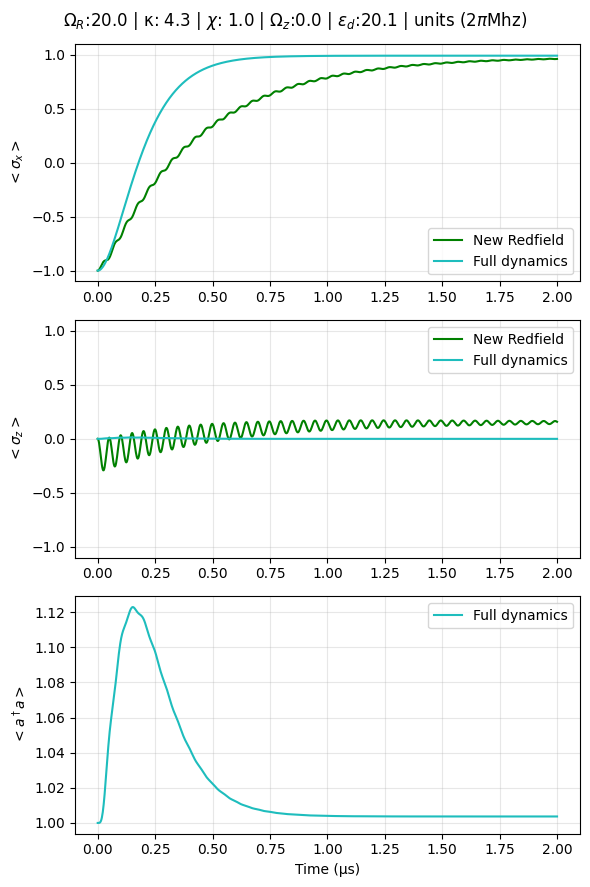

In [49]:
# Calculate expectations values.
d = tensor(destroy(N), qeye(2))   
sz = tensor(qeye(N), sigmaz())  
sx = tensor(qeye(N), sigmax())     
sm = tensor(qeye(N), sigmam()) 

x_exp_polaron = expect(sx, dynamics_polaron)
z_exp_polaron = expect(sz, dynamics_polaron)
photon_number_polaron = expect(d.dag()*d, dynamics_polaron)

# x_exp_normal = expect(sx, dynamics_normal)
# z_exp_normal = expect(sz, dynamics_normal)
# photon_number_normal = expect(d.dag()*d, dynamics_normal)

# x_exp_redfield = expect(sigmax(), dynamics_redfield)
# z_exp_redfield = expect(sigmaz(), dynamics_redfield)

x_exp_tredfield = expect(sigmax(), dynamics_tdep_redfield)
z_exp_tredfield = expect(sigmaz(), dynamics_tdep_redfield)



# Generate plot
max_time = None
if max_time is None:
    max_time = max(tlist)

time_mask = tlist <= max_time
tlist_plot = tlist[time_mask]

# Create plot
fig, axes = plt.subplots(3, 1, figsize=(6, 9))

# Plot only up to max_time
axes[0].plot(tlist_plot, x_exp_tredfield[time_mask], color='#008000', label='New Redfield')
axes[1].plot(tlist_plot, z_exp_tredfield[time_mask], color='#008000', label='New Redfield')
#axes[2].plot(tlist_plot, photon_number_tredfield[time_mask], color='#008000', label='Full dynamics')

axes[0].plot(tlist_plot, x_exp_polaron[time_mask], color="#1EBDBD", label='Full dynamics')
axes[1].plot(tlist_plot, z_exp_polaron[time_mask], color="#1EBDBD", label='Full dynamics')
axes[2].plot(tlist_plot, photon_number_polaron[time_mask], color="#1EBDBD", label='Full dynamics')



# Format σ_x plot
axes[0].set_ylabel(r'$<\sigma_x>$')
axes[0].legend()
axes[0].set_ylim(-1.1, 1.1)
axes[0].grid(True, alpha=0.3)

# Format σ_z plot  
axes[1].set_ylabel(r'$<\sigma_z>$')
axes[1].legend()
axes[1].set_ylim(-1.1, 1.1)
axes[1].grid(True, alpha=0.3)

# Format photon number plot
axes[2].set_ylabel(r'$<a^\dagger a>$')
axes[2].set_xlabel('Time (μs)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

params_text = []
params_text.append(r"$\Omega_R$:"+f"{rabi_freq/(2*np.pi*1e6):.1f}")
params_text.append(f"κ: {cavity_diss_rate/(2*np.pi*1e6):.1f}")
params_text.append(r"$\chi$" + f": {eff_coupling/(2*np.pi*1e6):.1f}")
params_text.append(r"$\Omega_z$:"+f"{qubit_targetz/(2*np.pi*1e6):.1f}")
params_text.append(r"$\epsilon_d$:"+f"{cavity_drive_amplitude/(2*np.pi*1e6):.1f}")

params_text.append(r"units (2$\pi$Mhz)")
plt.suptitle(' | '.join(params_text), y=0.98)

plt.tight_layout()
plt.show()

In [ ]:
N = 10
cavity_diss_rate = (4.3)*2*np.pi*10**6
eff_coupling = (1)*2*np.pi*10**6
input_power = (0)
rabi_freq = (20)*2*np.pi*10**6
qubit_targetz = (0)*2*np.pi*10**6
final_time__mus = 2
time_steps = 1000
tlist = np.linspace(0, final_time__mus, time_steps)
norm = eff_coupling
target_state = 'down'

parameters = {
    "N": N,
    "final_time__mus": final_time__mus,
    "time_steps": time_steps,
    "input_power": input_power,
    "rabi_freq": rabi_freq,
    "eff_coupling": eff_coupling,
    "qubit_targetz": qubit_targetz,
    "cavity_diss_rate": cavity_diss_rate,
    "norm": norm,
    "target_state": target_state
}


parameters = sb.calculate_cavity_drive_amplitude_normal_shift(parameters)
cavity_drive_amplitude = parameters['cavity_drive_amplitude']
parameters = sb.get_initial_cavity_state_normal_shift(parameters)
parameters = sb.get_initial_qubit_state(parameters)

parameters_polaron = sb.calculate_parameters_polaron(parameters)
dynamics_polaron = sb.calculate_full_dynamics(parameters_polaron)
print("polaron")

#parameters_normal = sb.calculate_parameters_normal_shift(parameters)
#dynamics_normal = sb.calculate_full_dynamics(parameters_normal)
#print("polaron")

#dynamics_redfield = sb.calculate_redfield_dynamics(parameters_normal)
#print("polaron")

dynamics_tdep_redfield = sb.calculate_tdep_redfield_dynamics(parameters_polaron)
print("polaron")

dynamics_tdep_redfield_polaron2 = calculate_tdep_redfield_dynamics_polaron2(parameters_polaron)




KeyboardInterrupt: 

In [ ]:
def calculate_redfield_dynamics_polaron4(parameters):

    #Retrieve needed parameters from the dictionary.
    N = parameters['N']
    cavity_diss_rate = parameters['cavity_diss_rate']
    input_power = parameters['input_power']
    rabi_freq = parameters['rabi_freq']
    eff_coupling = parameters['eff_coupling']
    qubit_detuning = parameters['qubit_detuning']
    cavity_drive_amplitude = parameters['cavity_drive_amplitude']
    cavity_detuning = parameters['cavity_detuning']
    norm = parameters['norm']
    final_time__mus = parameters['final_time__mus'] 
    time_steps = parameters["time_steps"]
    psi0_atom = parameters['initial_state_qubit']
    tlist = np.linspace(0, final_time__mus, time_steps)/(10**6)


    cavity_field = cavity_drive_amplitude/(-cavity_detuning + .5j*cavity_diss_rate)
    cavity_photon_number = np.real(cavity_field*np.conj(cavity_field))


    cavity_field_e = cavity_drive_amplitude/(-(cavity_detuning + eff_coupling) + .5j*cavity_diss_rate)
    cavity_field_g = cavity_drive_amplitude/(-(cavity_detuning - eff_coupling) + .5j*cavity_diss_rate)

    B = np.real(cavity_field_e*np.conj(cavity_field_g))

    qubit_detuning_lamb_shift = eff_coupling*(2*B+1)
    
    diag_qubit_freq = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5

    coupling_sz = eff_coupling*qubit_detuning_lamb_shift/diag_qubit_freq
    coupling_sx = eff_coupling*rabi_freq/diag_qubit_freq

    #Norm everything
    tlist__N = tlist*norm
    cavity_detuning__N = cavity_detuning/norm
    cavity_drive_amplitude__N = cavity_drive_amplitude/norm
    qubit_detuning__N = qubit_detuning/norm
    eff_coupling__N = eff_coupling/norm
    rabi_freq__N = rabi_freq/norm
    cavity_diss_rate__N = cavity_diss_rate/norm
    qubit_detuning_lamb_shift__N = qubit_detuning_lamb_shift/norm
    diag_qubit_freq__N = diag_qubit_freq/norm
    coupling_sz__N = coupling_sz/norm
    coupling_sx__N = coupling_sx/norm



    ### Qubit Hamiltonian ###
    sz = sigmaz()
    sx = sigmax()
    sm = sigmam()

    sz_matrix = sz.full()
    sx_matrix = sx.full()
    sm_matrix = sm.full()
    H_qubit_matrix = 5*diag_qubit_freq__N*sz_matrix

    ### Redfield operators ###
    u1 = (B*coupling_sz__N/(-1j*cavity_detuning__N + cavity_diss_rate__N/2)*sz_matrix \
        +  B*coupling_sx__N/(1j*(-diag_qubit_freq__N - cavity_detuning__N) + cavity_diss_rate__N/2)*sm_matrix.T \
        +  B*coupling_sx__N/(1j*(diag_qubit_freq__N - cavity_detuning__N) + cavity_diss_rate__N/2)*sm_matrix )

    s1 = coupling_sz__N*sz_matrix + coupling_sx__N*sx_matrix

    theta = np.arctan2(rabi_freq, qubit_detuning_lamb_shift)

    U = (1j * theta/2 * sigmay()).expm()

    rho0 = U*psi0_atom@psi0_atom.dag()*U.dag()
    rho0_matrix = rho0.full()
    rho0_vectorized = rho0_matrix.flatten()
    max_step =  0.05/np.max([diag_qubit_freq__N, coupling_sz__N, coupling_sx__N,])

    sol = solve_ivp(sb.redfield_master_equation, (tlist__N[0], tlist__N[-1]), rho0_vectorized, method="DOP853",
                    t_eval=tlist__N, max_step=max_step, args=(H_qubit_matrix, [u1], [s1]))

    full_dynamics = sol.y.T.reshape(time_steps, 2, 2)

    dynamics = [U.dag()*Qobj(i, dims=[[2], [2]])*U for i in full_dynamics]

    return dynamics


def tdep_redfield_master_equation_polaron4(t, rho_vec, hamiltonian, parameters, sz_matrix, sm_matrix, S_operators):

    Z_operators = tdep_Z_operators_polaron4(parameters, sz_matrix, sm_matrix, t)

    return sb.redfield_master_equation(t, rho_vec, hamiltonian, Z_operators, S_operators)

def tdep_Z_operators_polaron4(parameters, sz_matrix, sm_matrix, t):
    Zop_term1__N = parameters["Zop_term1__N"]
    Zop_term2__N = parameters["Zop_term2__N"]
    Zop_term3__N = parameters["Zop_term3__N"]
    diag_qubit_freq__N = parameters["diag_qubit_freq__N"]
    cavity_diss_rate__N = parameters["cavity_diss_rate__N"]
    cavity_detuning__N = parameters["cavity_detuning__N"]

    term1 = Zop_term1__N*(np.exp(1j*cavity_detuning__N*t - cavity_diss_rate__N*t)-1)*sz_matrix
    term2 = Zop_term2__N*(np.exp(1j*(diag_qubit_freq__N+cavity_detuning__N)*t - cavity_diss_rate__N*t)-1)*sm_matrix.T
    term3 = Zop_term3__N*(np.exp(1j*(-diag_qubit_freq__N+cavity_detuning__N)*t - cavity_diss_rate__N*t)-1)*sm_matrix

    u1 =  term1 + term2 + term3

    return [u1]



def calculate_tdep_redfield_dynamics_polaron4(parameters):

    #Retrieve needed parameters from the dictionary.
    N = parameters['N']
    cavity_diss_rate = parameters['cavity_diss_rate']
    input_power = parameters['input_power']
    rabi_freq = parameters['rabi_freq']
    eff_coupling = parameters['eff_coupling']
    qubit_detuning = parameters['qubit_detuning']
    cavity_drive_amplitude = parameters['cavity_drive_amplitude']
    cavity_detuning = parameters['cavity_detuning']
    norm = parameters['norm']
    final_time__mus = parameters['final_time__mus'] 
    time_steps = parameters["time_steps"]
    psi0_atom = parameters['initial_state_qubit']
    tlist = np.linspace(0, final_time__mus, time_steps)/(10**6)


    cavity_field_e = cavity_drive_amplitude/(-(cavity_detuning + eff_coupling) + .5j*cavity_diss_rate)
    cavity_field_g = cavity_drive_amplitude/(-(cavity_detuning - eff_coupling) + .5j*cavity_diss_rate)

    B = np.real(cavity_field_e*np.conj(cavity_field_g))
    
    qubit_detuning_lamb_shift = qubit_detuning + eff_coupling*(2*B + 1)

    diag_qubit_freq = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5
    coupling_sz = eff_coupling*qubit_detuning_lamb_shift/diag_qubit_freq
    coupling_sx = eff_coupling*rabi_freq/diag_qubit_freq

    #Norm everything
    tlist__N = tlist*norm
    cavity_detuning__N = cavity_detuning/norm
    cavity_drive_amplitude__N = cavity_drive_amplitude/norm
    qubit_detuning__N = qubit_detuning/norm
    eff_coupling__N = eff_coupling/norm
    rabi_freq__N = rabi_freq/norm
    cavity_diss_rate__N = cavity_diss_rate/norm
    qubit_detuning_lamb_shift__N = qubit_detuning_lamb_shift/norm
    diag_qubit_freq__N = diag_qubit_freq/norm
    coupling_sz__N = coupling_sz/norm
    coupling_sx__N = coupling_sx/norm

    parameters_red = parameters
    parameters_red["diag_qubit_freq__N"] = diag_qubit_freq__N
    parameters_red["coupling_sz__N"] = coupling_sz__N
    parameters_red["coupling_sx__N"] = coupling_sx__N
    parameters_red["cavity_detuning__N"] = cavity_detuning__N
    parameters_red["cavity_diss_rate__N"] = cavity_diss_rate__N

    ### Qubit Hamiltonian ###
    sz = sigmaz()
    sx = sigmax()
    sm = sigmam()

    sz_matrix = sz.full()
    sx_matrix = sx.full()
    sm_matrix = sm.full()
    H_qubit_matrix = .5*diag_qubit_freq__N*sz_matrix

    ### Redfield operators ###
    Zop_term1__N = B*coupling_sz__N/(1j*cavity_detuning__N - cavity_diss_rate__N/2)
    Zop_term2__N = B*coupling_sx__N/(1j*(diag_qubit_freq__N + cavity_detuning__N) - cavity_diss_rate__N/2)
    Zop_term3__N = B*coupling_sx__N/(1j*(diag_qubit_freq__N - cavity_detuning__N) - cavity_diss_rate__N/2)

    parameters_red["Zop_term1__N"]=Zop_term1__N
    parameters_red["Zop_term2__N"]=Zop_term2__N
    parameters_red["Zop_term3__N"]=Zop_term3__N

    s1 = coupling_sz__N*sz_matrix + coupling_sx__N*sx_matrix

    theta = np.arctan2(rabi_freq, qubit_detuning_lamb_shift)

    U = (1j * theta/2 * sigmay()).expm()

    rho0 = U*psi0_atom@psi0_atom.dag()*U.dag()
    rho0_matrix = rho0.full()
    rho0_vectorized = rho0_matrix.flatten()
    max_step =  0.05/np.max([diag_qubit_freq__N, coupling_sz__N, coupling_sx__N,])

    sol = solve_ivp(tdep_redfield_master_equation_polaron4, (tlist__N[0], tlist__N[-1]), rho0_vectorized, method="DOP853",
                    t_eval=tlist__N, max_step=max_step, args=(H_qubit_matrix, parameters_red, sz_matrix, sm_matrix, [s1]))

    full_dynamics = sol.y.T.reshape(time_steps, 2, 2)

    dynamics = [U.dag()*Qobj(i, dims=[[2], [2]])*U for i in full_dynamics]
    return dynamics


In [ ]:
N = 10
cavity_diss_rate = (4.3)*2*np.pi*10**6
eff_coupling = (5)*2*np.pi*10**6
input_power = (0)
rabi_freq = (20)*2*np.pi*10**6
qubit_targetz = (0)*2*np.pi*10**6
final_time__mus = 2
time_steps = 1000
tlist = np.linspace(0, final_time__mus, time_steps)
norm = eff_coupling
target_state = 'down'

parameters = {
    "N": N,
    "final_time__mus": final_time__mus,
    "time_steps": time_steps,
    "input_power": input_power,
    "rabi_freq": rabi_freq,
    "eff_coupling": eff_coupling,
    "qubit_targetz": qubit_targetz,
    "cavity_diss_rate": cavity_diss_rate,
    "norm": norm,
    "target_state": target_state
}


parameters = sb.calculate_cavity_drive_amplitude_normal_shift(parameters)
cavity_drive_amplitude = parameters['cavity_drive_amplitude']
parameters = sb.get_initial_cavity_state_normal_shift(parameters)
parameters = sb.get_initial_qubit_state(parameters)

parameters_polaron = sb.calculate_parameters_polaron(parameters)
dynamics_redfield_polaorn4 = calculate_redfield_dynamics_polaron4(parameters_polaron)
dynamics_polaron = sb.calculate_full_dynamics(parameters_polaron)
dynamics_redfield = sb.calculate_redfield_dynamics(parameters_polaron)
dynamics_tdep_redfield = sb.calculate_tdep_redfield_dynamics(parameters_polaron)


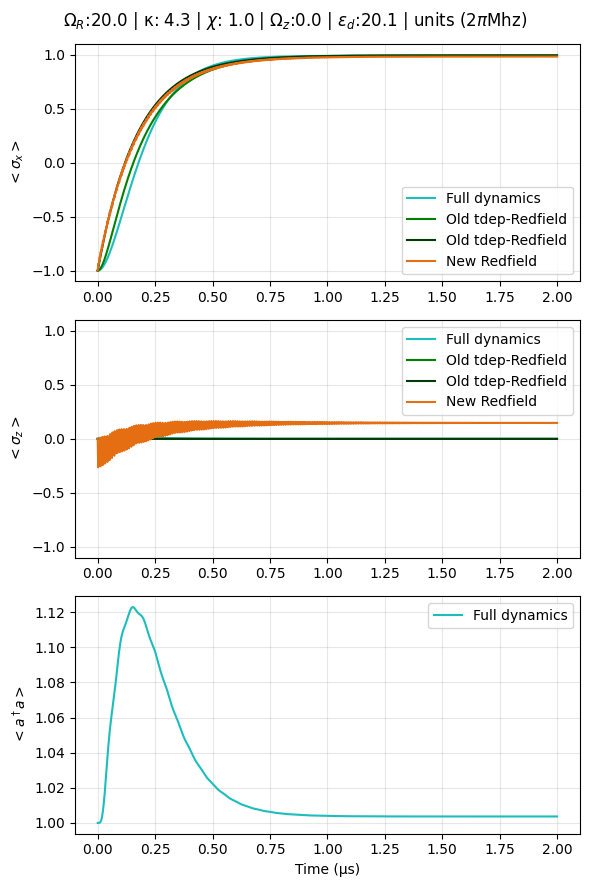

In [8]:
# Calculate expectations values.
d = tensor(destroy(N), qeye(2))   
sz = tensor(qeye(N), sigmaz())  
sx = tensor(qeye(N), sigmax())     
sm = tensor(qeye(N), sigmam()) 

x_exp_polaron = expect(sx, dynamics_polaron)
z_exp_polaron = expect(sz, dynamics_polaron)
photon_number_polaron = expect(d.dag()*d, dynamics_polaron)

# x_exp_normal = expect(sx, dynamics_normal)
# z_exp_normal = expect(sz, dynamics_normal)
# photon_number_normal = expect(d.dag()*d, dynamics_normal)

x_exp_redfield = expect(sigmax(), dynamics_redfield)
z_exp_redfield = expect(sigmaz(), dynamics_redfield)

x_exp_tredfield = expect(sigmax(), dynamics_tdep_redfield)
z_exp_tredfield = expect(sigmaz(), dynamics_tdep_redfield)

x_exp_redfield_polaron = expect(sigmax(), dynamics_redfield_polaorn4)
z_exp_redfield_polaron = expect(sigmaz(), dynamics_redfield_polaorn4)



# Generate plot
max_time = None
if max_time is None:
    max_time = max(tlist)

time_mask = tlist <= max_time
tlist_plot = tlist[time_mask]

# Create plot
fig, axes = plt.subplots(3, 1, figsize=(6, 9))

# Plot only up to max_time
axes[0].plot(tlist_plot, x_exp_polaron[time_mask], color="#1EBDBD", label='Full dynamics')
axes[1].plot(tlist_plot, z_exp_polaron[time_mask], color="#1EBDBD", label='Full dynamics')
axes[2].plot(tlist_plot, photon_number_polaron[time_mask], color="#1EBDBD", label='Full dynamics')

axes[0].plot(tlist_plot, x_exp_tredfield[time_mask], color='#008000', label='Old tdep-Redfield')
axes[1].plot(tlist_plot, z_exp_tredfield[time_mask], color='#008000', label='Old tdep-Redfield')

axes[0].plot(tlist_plot, x_exp_redfield[time_mask], color="#043A06", label='Old tdep-Redfield')
axes[1].plot(tlist_plot, z_exp_redfield[time_mask], color='#043A06', label='Old tdep-Redfield')

axes[0].plot(tlist_plot, x_exp_redfield_polaron[time_mask], color="#E56E13", label='New Redfield')
axes[1].plot(tlist_plot, z_exp_redfield_polaron[time_mask], color='#E56E13', label='New Redfield')



# Format σ_x plot
axes[0].set_ylabel(r'$<\sigma_x>$')
axes[0].legend()
axes[0].set_ylim(-1.1, 1.1)
axes[0].grid(True, alpha=0.3)

# Format σ_z plot  
axes[1].set_ylabel(r'$<\sigma_z>$')
axes[1].legend()
axes[1].set_ylim(-1.1, 1.1)
axes[1].grid(True, alpha=0.3)

# Format photon number plot
axes[2].set_ylabel(r'$<a^\dagger a>$')
axes[2].set_xlabel('Time (μs)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

params_text = []
params_text.append(r"$\Omega_R$:"+f"{rabi_freq/(2*np.pi*1e6):.1f}")
params_text.append(f"κ: {cavity_diss_rate/(2*np.pi*1e6):.1f}")
params_text.append(r"$\chi$" + f": {eff_coupling/(2*np.pi*1e6):.1f}")
params_text.append(r"$\Omega_z$:"+f"{qubit_targetz/(2*np.pi*1e6):.1f}")
params_text.append(r"$\epsilon_d$:"+f"{cavity_drive_amplitude/(2*np.pi*1e6):.1f}")

params_text.append(r"units (2$\pi$Mhz)")
plt.suptitle(' | '.join(params_text), y=0.98)

plt.tight_layout()
plt.show()